This notebook loads the data from trajectory_analysis_script.py for whichever data set is needed. The point is to look at the density of the tracks/localizations per area of the cell.

In [1]:
from src.databases.trajectory_analysis_script import *
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
import os
import numpy as np
from src.helpers.plotting_functions import *
from src.helpers.import_functions import *
from src.helpers.Analysis_functions import *
from src.helpers.diff_mw import *
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib as mpl
from src.helpers.scalebars import *
from src.helpers.Convert_csv_mat import *
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import stats, ndimage
import csv  
from sklearn.cluster import OPTICS
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')  
from sklearn.cluster import DBSCAN
from cgitb import small
import src.helpers.smallestenclosingcircle as smallestenclosingcircle
import math
import src.helpers.guassian_fit as gaussian_fit
import src.helpers.fbm_utility as fbm_utility
import src.helpers.simulate_foci as simulate_foci
import src.helpers.simulate_cells as simulate_cells

import matplotlib.patches as mpatches
import pickle

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_61082/292435484.py:30: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
globals = {"olympus_pixel_size":130,"confocal_pixel_size":79}

In [3]:
%matplotlib widget


Testing the simulations

In [4]:
#cell parameters
cell_parms = {
    "diffusion_coefficients":1e-2*np.ones(100),
    "initials":np.random.uniform(50,150,(100,2)),
    "num_tracks":100,
    "track_type":"fbm",
    "hursts":0.5*np.ones(100),
    "dims":(200,200),
    "movie_frames":500
}      

#sim_params
sim_params = {
    "track_length_mean":10,
    "track_distribution":"exponential",
    "exposure_time":20,#ms same as frame_time
    "base_noise":140,
    "point_intensity":20,
    "psf_sigma":0.82,
    "frame_time":20,#ms
    "pixel_size":globals["confocal_pixel_size"],
}
cell_sim = simulate_cells.Simulate_cells(cell_parms,sim_params)
a = cell_sim.get_cell()


2023-01-31 16:23:46.814259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-31 16:23:46.814536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



[array([80.02941373, 78.71522932]), array([116.22148332,  64.03017348]), array([135.54768576,  59.44259997]), array([141.40053453, 127.97365099]), array([128.23728313, 117.48007011])]


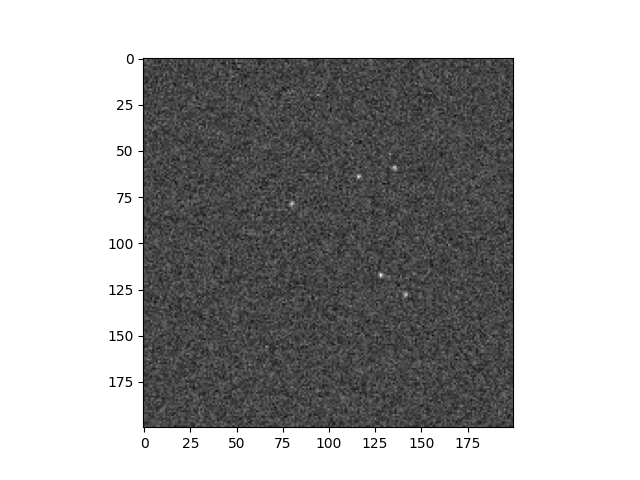

500


[array([[140.36 , 140.378, 140.346, ..., 139.94 , 140.4  , 139.302],
        [140.388, 140.156, 140.174, ..., 139.752, 140.262, 140.23 ],
        [139.748, 140.46 , 140.886, ..., 140.606, 139.582, 139.86 ],
        ...,
        [140.372, 139.974, 139.204, ..., 140.222, 140.366, 140.294],
        [139.85 , 139.284, 139.692, ..., 140.206, 138.982, 140.278],
        [139.78 , 140.88 , 139.984, ..., 139.996, 141.136, 139.914]])]

In [5]:
print(a["points_per_frame"]["42"])

#plot the first frame of the cell
plt.figure()
plt.imshow(a["map"][42],cmap="gray")
plt.show()
print(a["map"].shape[0])

simulate_cells.make_directory_structure("/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/h_0.5_track_100_diff_001_random/","test_seg",a["map"],"mean",1,
                                        data=a,params={"cell_parms":cell_parms,"sim_params":sim_params})

In [ ]:
with open("/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/h_0.5_track_100_diff_001_random/Track_dump.pkl", 'rb') as f:
    loaded_dict = pickle.load(f)
print(len(loaded_dict["tracks"]))

In [21]:
rp_ez= run_analysis(wd="/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/h_0.5_track_100_diff_001_random",
                    t_string="test_seg",sim=True)
                    
rp_ez.read_parameters(minimum_percent_per_drop_in = 0.5, 
                    t_len_u = 100, 
                    t_len_l=1, 
                    minimum_tracks_per_drop = 3,
                    frame_step=500,
                    frame_total=500)

rp_ez.get_blob_parameters(threshold=1e-2,
                        overlap=0,
                        detection_name='bp',
                        min_sigma=1/np.sqrt(2),
                        max_sigma=6/np.sqrt(2),
                        num_sigma=500,median = False)

rp_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":2,
                                    "centroid_range":0.5,
                                    "height_range":2})
rp_ez.run_flow_sim("/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/h_0.5_track_100_diff_001_random","test_seg")

[[array([[  0.        , 148.12791535, 117.78144416,  22.        ,
          160.23809524],
         [  0.        , 147.97151404, 117.68198194,  21.        ,
          161.42857143],
         [  0.        , 148.48085196, 117.28771919,  23.        ,
          156.0952381 ],
         ...,
         [101.        ,  87.52127587, 120.32587932, 483.        ,
          161.76190476],
         [102.        , 144.99503242,  79.06495605, 499.        ,
          157.71428571],
         [102.        , 145.42304842,  79.24928351, 498.        ,
          157.0952381 ]])],
 [],
 [[{'Fitted': array([[ 94.19710765, 117.90137155,   1.17519723,   1.20654889],
           [141.54749485,  89.80694605,   1.09325998,   1.25627125],
           [103.72091684, 105.1381056 ,   1.40300021,   1.29321079],
           [ 64.25043432, 136.45248733,   1.35894563,   1.40152999],
           [111.31274632,  66.23590611,   1.48141455,   1.57504399]]),
    'Scale': array([[ 94., 118.,   1.],
           [142.,  90.,   1.],
    

{'no_drop': [], 'in_drop': [[0.01527570578900573, 25], [0.03098576723249959, 5], [0.0137904981376364, 9]], 'ot_drop': [[0.01961024980838989, 4], [0.006374989315032375, 6], [0.009597313836839524, 17], [0.019280601174288804, 11], [0.018914645393265334, 14], [0.01209904174987162, 11], [0.03475993775620729, 21], [0.04687321927133043, 3], [nan, 2], [0.08294453659408432, 4], [0.025852395969255385, 3], [0.02251462846638307, 15], [nan, 2], [0.012028484733993669, 11], [0.009695983774621561, 10], [0.001752625740526676, 6], [0.018139200346537758, 39], [nan, 2], [0.030397950209522136, 32], [0.014255358290143605, 12], [0.04294370806887716, 8], [0.006395964325924013, 4], [0.035349591593304135, 16], [0.01476272464247631, 11], [0.02461778286299844, 3], [0.00018225844957084713, 3], [0.0136288109183422, 7], [0.02949127613058741, 6], [0.02285678816346816, 22], [0.011246550272124818, 22], [0.04317011877552994, 3], [nan, 2], [0.01132214131290715, 5], [0.003465392102396517, 3], [0.001666208839102931, 4], [n

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

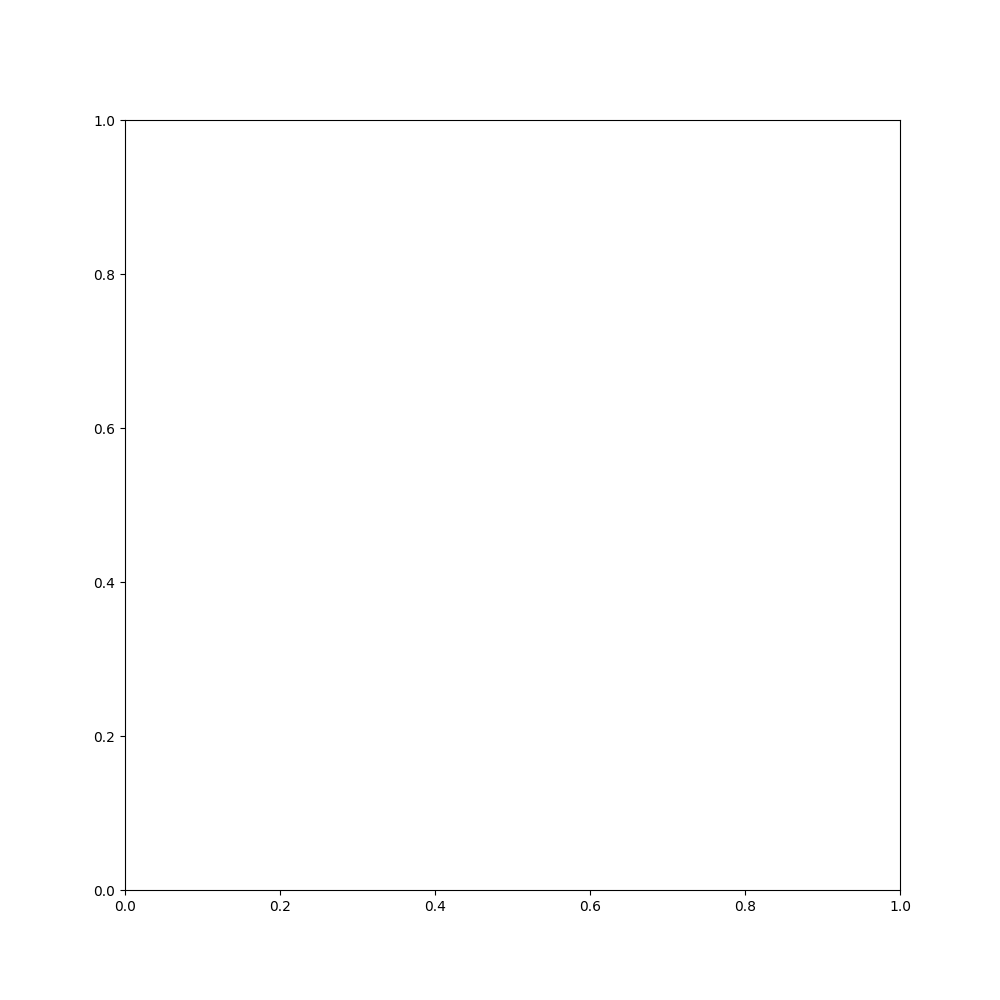

In [22]:
a = rp_ez._bulk_msd_plot()
print(a)
#make a figure 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#plot the "no_drop" data as a scatter plot of msd vs length of track
ax.scatter(np.array(a["no_drop"])[:,0],np.array(a["no_drop"])[:,1])
#label the axes
ax.set_ylabel("Track Length")
ax.set_xlabel("MSD")
#plot a vertical line at msd = 1e-2
ax.axvline(x=1e-2,linestyle="--",color="red")
#show the plot
plt.show()





In [ ]:
#find files
def find_files(path, extension, keyword = None):
    '''
    Docstring for find_files
    Finds files in a directory with a specific extension and keyword in the name

    Parameters:
    -----------
    path : str
        path to the directory where the files are located
    extension : str
        extension of the files to be found
    keyword : str    
        keyword to be searched in the file name
    Returns:
    --------
    files : list
        list of files that match the criteria
    '''
    #find all images in the directory using import functions
    files = import_functions.find_image(path=path,ends_with=extension,full_path=True)
    #sort the files to get only ones conatining the word "RFP" for the flourescent protein
    files = import_functions.name_sorter(strings=files,keyword=keyword)
    return files

In [ ]:
#run detection on a set of files 
def utility_batch_blob_detection(files,detection_args,fitting_args,focal_plane=None,project=False):
    '''
    Docstring for utility_batch_blob_detection
    Runs blob detection on a set of files and returns the blobs in a list

    Parameters:
    -----------
    files : list
        list of files to be analyzed
    detection_args : dict
        dictionary of arguments for the blob detection
    fitting_args : dict 
        dictionary of arguments for the blob fitting
    focal_plane : int
        focal plane to be analyzed in each image (default is None if there is only one plane)
    project : bool
        whether or not to project the image using max (default is False), focal_plane must be None if project is True

    Returns:
    --------
    blobs : list
        list of blobs detected in each image aggregated in a list
    
    Notes:
    ------
    This doesn't care if the detection is verbose, the list may be a list of lists or a list of dictionaries, see blob_detection.detection for more details
    '''
    blobs=[]
    for i in files:
        if project:
            img = np.max(io.imread(i),axis=0)
        else:
            img = io.imread(i)[focal_plane]
        blob_detector = blob_detection(path=img,**detection_args)
        blob_detector._update_fitting_parameters(kwargs=fitting_args)
        #detect blobs
        c = blob_detector.detection(type="bp")
        #if c's shape's first element is 0, then there are no blobs detected and we don't want to add it to the list
        if blob_detector.verbose:
            if c["Fitted"].shape[0] != 0:
                blobs.append(c["Fitted"])
        else:
            if c.shape[0] != 0:
                blobs.append(c)
            
    return blobs

test the blob detection on hupA images and generic RpoC images from the confocal

In [ ]:
#list of paths of hupa images
hupa_dir_list = ["/Volumes/WEBERLAB/HupA_confocal/191113_TC_WLBS81(HupA)/t120/",
                "/Volumes/WEBERLAB/HupA_confocal/191205_TC_WLBS81(HupA)/t120",
                "/Volumes/WEBERLAB/HupA_confocal/191223_TC_WLBS81(HupA)/t120",
                "/Volumes/WEBERLAB/HupA_confocal/191230_TC_WLBS81(HupA)/t120"]

In [ ]:
#directory of AML's rpoc images
aml_rpoc_dir = "/Volumes/WEBERLAB/HupA_confocal/thirty-seven/120"

In [ ]:
#using find_files, find hupa files
#using all the hupa directories find all the files with the keyword "RFP"
files_hupa = []
for i in hupa_dir_list:
    files_hupa+=find_files(path=i,extension="*.tif",keyword="RFP")
#using find_files, find rpoc files
files_rpoc = find_files(path="/Volumes/WEBERLAB/HupA_confocal/191205_TC_WLBS100(rpoC)/t120",extension="*.tif",keyword="RFP")
#find aml rpoc files
files_aml_rpoc = find_files(path=aml_rpoc_dir,extension="*.tif",keyword="RFP")

In [ ]:
#define the parameters for blob detection
detection_args = {"median":False,
                "threshold":7e-2,
                "min_sigma":1./np.sqrt(2),
                "max_sigma":20./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":4,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":None,
                "residual_func":residuals_gaus2d,
                "sigma_range":0.5,
                "centeroid_range":0.5}

In [ ]:
#run utility_batch_blob_detection on the hupa files
blobs_hupa = utility_batch_blob_detection(files_hupa,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)
#run utility_batch_blob_detection on the rpoc files
blobs_rpoc = utility_batch_blob_detection(files_rpoc,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)
#run utility_batch_blob_detection on the aml rpoc files
blobs_aml_rpoc = utility_batch_blob_detection(files_aml_rpoc,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)

In [ ]:
#redo the detection on the AML rpoC images with detection args with threshold changed 
detection_args_AML = detection_args.copy()
detection_args_AML["threshold"] = 1e-1
detection_args_AML["overlap"] = 0
#run utility_batch_blob_detection on the aml rpoc files
blobs_aml_rpoc = utility_batch_blob_detection(files_aml_rpoc,detection_args=detection_args_AML,fitting_args=fitting_args,focal_plane=3,project=False)


In [ ]:

def get_blob_sizes(blobs,verbose=False):
    '''Return a flattened list of blob sizes
    
    Parameters:
    -----------
    blobs : list
        list of blobs detected in each image aggregated in a list
    verbose : bool
        True whether the blobs are Fitted and have sigma_x, and sigma_y. Or Flase if isotropic gaussian is used/Scale space (default is False)
    '''
    if verbose:
        return [np.concatenate([i[:,2] for i in blobs]).ravel(),np.concatenate([i[:,3] for i in blobs]).ravel()]
    else:
        return np.concatenate([i[:,2] for i in blobs]).ravel()
    


In [ ]:
#sizes of the blobs if verbose is True, if false do not run this cell
sizes_hupa = get_blob_sizes(blobs_hupa,verbose=True)
sizes_rpoc = get_blob_sizes(blobs_rpoc,verbose=True)
sizes_aml_rpoc = get_blob_sizes(blobs_aml_rpoc,verbose=True)

#for each, find the ratio of the x and y sigma
ratio_hupa = sizes_hupa[0]/sizes_hupa[1]
ratio_rpoc = sizes_rpoc[0]/sizes_rpoc[1]
ratio_aml_rpoc = sizes_aml_rpoc[0]/sizes_aml_rpoc[1]

#plot the ratio of the x and y sigma as a histogram with the bins=20
#Make sure the weights are normalized

#make a figure with two subplots
fig,ax = plt.subplots(1,2,figsize=(10,5))
#redo the first plot on the first axis
ax[0].hist(ratio_hupa,bins=20,weights=np.ones_like(ratio_hupa)/len(ratio_hupa),label="HupA",alpha=0.2)
ax[0].hist(ratio_rpoc,bins=20,weights=np.ones_like(ratio_rpoc)/len(ratio_rpoc),label="rpoC",alpha=0.2)
ax[0].hist(ratio_aml_rpoc,bins=20,weights=np.ones_like(ratio_aml_rpoc)/len(ratio_aml_rpoc),label="AML rpoC",alpha=0.2)
ax[0].legend()
ax[0].set_xlabel(r"$\frac{\sigma_x}{\sigma_y}$",fontsize=20)
ax[0].set_ylabel("Probability")
ax[0].set_title("Ratio of x and y sigma for HupA and rpoC blobs")
#redo the second plot on the second axis
#find the mean of each x,y pair
#make sure to divide by sqrt(2) because of the blob_detection output scales the sigma by sqrt(2)

mean_hupa = np.mean(sizes_hupa,axis=0)/np.sqrt(2)
mean_rpoc = np.mean(sizes_rpoc,axis=0)/np.sqrt(2)
mean_aml_rpoc = np.mean(sizes_aml_rpoc,axis=0)/np.sqrt(2)

#plot the mean of the x and y sigma vs the ratios calculated above, make sure to multiply the mean by the confocal pixel size to get the correct units in nm
ax[1].scatter(mean_hupa*globals["confocal_pixel_size"],ratio_hupa,label="HupA")
ax[1].scatter(mean_rpoc*globals["confocal_pixel_size"],ratio_rpoc,label="rpoC")
ax[1].scatter(mean_aml_rpoc*globals["confocal_pixel_size"],ratio_aml_rpoc,label="AML rpoC")
ax[1].legend()
#write the the sigma as greek letters and make the font size of the labels bigger

ax[1].set_ylabel(r"$\frac{\sigma_x}{\sigma_y}$",fontsize=20)
ax[1].set_xlabel(r"$\frac{\sigma_x + \sigma_y}{2}$ nm",fontsize=20)
ax[1].set_title("Mean of x and y sigma vs \n Ratio of x and y sigma for HupA and rpoC blobs")
#make the plot look nice
plt.tight_layout()
plt.show()


#find the absolute differences in the x and y sigmas for each blob
diff_hupa = np.abs(sizes_hupa[0]-sizes_hupa[1])/np.sqrt(2)
diff_rpoc = np.abs(sizes_rpoc[0]-sizes_rpoc[1])/np.sqrt(2)
diff_aml_rpoc = np.abs(sizes_aml_rpoc[0]-sizes_aml_rpoc[1])/np.sqrt(2)

#plot this as a scatter plot vs the mean of the x and y sigmas
#make a figure with one subplot
fig,ax = plt.subplots(1,1,figsize=(5,5))
#plot the scatter plot
ax.scatter(mean_hupa*globals["confocal_pixel_size"],diff_hupa*globals["confocal_pixel_size"],label="HupA")
ax.scatter(mean_rpoc*globals["confocal_pixel_size"],diff_rpoc*globals["confocal_pixel_size"],label="rpoC")
ax.scatter(mean_aml_rpoc*globals["confocal_pixel_size"],diff_aml_rpoc*globals["confocal_pixel_size"],label="AML rpoC")
ax.legend()
#write the the sigma as greek letters and make the font size of the labels bigger
#the y label is the absolute difference of the x and y sigma
ax.set_ylabel(r"$\left|\sigma_x - \sigma_y\right|$ nm",fontsize=20)
ax.set_xlabel(r"$\frac{\sigma_x + \sigma_y}{2}$ nm",fontsize=20)
ax.set_title("Mean of x and y sigma vs \n Absolute difference of x and y sigma for HupA and rpoC blobs")
#make the plot look nice
plt.tight_layout()
plt.show()






In [ ]:
#change the detection parameter verbose to False to see the progress of the blob detection
detection_args["verbose"] = False

#run utility_batch_blob_detection on the hupa files
blobs_hupa = utility_batch_blob_detection(files_hupa,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)
#run utility_batch_blob_detection on the rpoc files
blobs_rpoc = utility_batch_blob_detection(files_rpoc,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)
#run utility_batch_blob_detection on the aml rpoc files
blobs_aml_rpoc = utility_batch_blob_detection(files_aml_rpoc,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)


In [ ]:

#plot the two sizes on the same histogram plot with a legend and alpha transparency of 0.2, this does not work if verbose is True, do not run this cell if verbose is True
sizes_hupa = get_blob_sizes(blobs_hupa,verbose=False)
sizes_rpoc = get_blob_sizes(blobs_rpoc,verbose=False)
sizes_aml_rpoc = get_blob_sizes(blobs_aml_rpoc,verbose=False)

#make a figure with one subplot
plt.clf()
fig,ax = plt.subplots(1,1,figsize=(5,5))
#plot the histograms with the weights normaized to 1
ax.hist(sizes_hupa*globals["confocal_pixel_size"],bins=10,weights=np.ones_like(sizes_hupa)/len(sizes_hupa),label="HupA",alpha=0.2)
ax.hist(sizes_rpoc*globals["confocal_pixel_size"],bins=10,weights=np.ones_like(sizes_rpoc)/len(sizes_rpoc),label="rpoC",alpha=0.2)
ax.hist(sizes_aml_rpoc*globals["confocal_pixel_size"],bins=10,weights=np.ones_like(sizes_aml_rpoc)/len(sizes_aml_rpoc),label="AML rpoC",alpha=0.2)

#set the x and y labels
ax.set_xlabel("Size of blob (nm)")
ax.set_ylabel("Probaility")
#add a title
ax.set_title("Size of HupA and rpoC Blobs from Confocal Images")
#add an annotation for the mean and standard deviation for each distribution 
ax.annotate("HupA: $\mu$ = {:.2f} nm, $\sigma$ = {:.2f} nm".format(np.mean(sizes_hupa*globals["confocal_pixel_size"]),np.std(sizes_hupa*globals["confocal_pixel_size"])),xy=(0.05,0.9),xycoords="axes fraction")
ax.annotate("rpoC: $\mu$ = {:.2f} nm, $\sigma$ = {:.2f} nm".format(np.mean(sizes_rpoc*globals["confocal_pixel_size"]),np.std(sizes_rpoc*globals["confocal_pixel_size"])),xy=(0.05,0.85),xycoords="axes fraction")
ax.annotate("AML's rpoC: $\mu$ = {:.2f} nm, $\sigma$ = {:.2f} nm".format(np.mean(sizes_aml_rpoc*globals["confocal_pixel_size"]),np.std(sizes_aml_rpoc*globals["confocal_pixel_size"])),xy=(0.05,0.75),xycoords="axes fraction")
#annotate the result of a ks test both the p value and the statistic
ax.annotate("K-S Test: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]),xy=(0.05,0.8),xycoords="axes fraction")
#make the legend in the middle right of the plot
ax.legend(loc="center left")
plt.show()
print(np.max(sizes_hupa*globals["confocal_pixel_size"]))
print(np.min(sizes_hupa*globals["confocal_pixel_size"]))

In [ ]:
#find the mean and standard deviation of the hupa and rpoc blobs
print("HupA: mean = {:.2f} nm, std = {:.2f} nm".format(np.mean(sizes_hupa*globals["confocal_pixel_size"]),np.std(sizes_hupa*globals["confocal_pixel_size"])))
print("rpoC: mean = {:.2f} nm, std = {:.2f} nm".format(np.mean(sizes_rpoc*globals["confocal_pixel_size"]),np.std(sizes_rpoc*globals["confocal_pixel_size"])))
#do the same for the aml rpoc blobs
print("AML's rpoC: mean = {:.2f} nm, std = {:.2f} nm".format(np.mean(sizes_aml_rpoc*globals["confocal_pixel_size"]),np.std(sizes_aml_rpoc*globals["confocal_pixel_size"])))
#find the p value and the statistic of the ks test
print("K-S Test: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]))

#test if the two rpoc distributions are from the same distribution
print("K-S Test for rpoC and AML's rpoC: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_rpoc*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_rpoc*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[0]))

#test if AML's rpoC and HupA are from the same distribution
print("K-S Test for AML's rpoC and HupA: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[0]))

#Statistics 
#perform a wilcoxon rank sum test on the hupa and rpoc blobs
print("Wilcoxon Rank Sum Test: p_val = {:.2e}, W = {:.2f}".format(stats.ranksums(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.ranksums(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]))
#perform a mann whitney u test on the hupa and rpoc blobs
print("Mann Whitney U Test: p_val = {:.2e}, U = {:.2f}".format(stats.mannwhitneyu(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.mannwhitneyu(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]))

#check if the hupa and rpoc blobs are normally distributed
print("HupA: normal = {}, skew = {:.2f}, kurtosis = {:.2f}".format(stats.normaltest(sizes_hupa*globals["confocal_pixel_size"])[1]>0.05,stats.skew(sizes_hupa*globals["confocal_pixel_size"]),stats.kurtosis(sizes_hupa*globals["confocal_pixel_size"])))
print("rpoC: normal = {}, skew = {:.2f}, kurtosis = {:.2f}".format(stats.normaltest(sizes_rpoc*globals["confocal_pixel_size"])[1]>0.05,stats.skew(sizes_rpoc*globals["confocal_pixel_size"]),stats.kurtosis(sizes_rpoc*globals["confocal_pixel_size"])))
#check if the aml rpoc blobs are normally distributed
print("AML's rpoC: normal = {}, skew = {:.2f}, kurtosis = {:.2f}".format(stats.normaltest(sizes_aml_rpoc*globals["confocal_pixel_size"])[1]>0.05,stats.skew(sizes_aml_rpoc*globals["confocal_pixel_size"]),stats.kurtosis(sizes_aml_rpoc*globals["confocal_pixel_size"])))

#find the number of blobs in the hupa and rpoc files
print("HupA: number of blobs = {}".format(len(sizes_hupa)))
print("rpoC: number of blobs = {}".format(len(sizes_rpoc)))

#find the number of blobs in each file
print("HupA: number of blobs per file = {}".format([len(i) for i in blobs_hupa]))
print("rpoC: number of blobs per file = {}".format([len(i) for i in blobs_rpoc]))

#create a QQ plot for both the hupa and rpoc blobs to check if they are normally distributed. Do this on the same plot
plt.clf()
stats.probplot(sizes_hupa*globals["confocal_pixel_size"],dist="norm",plot=plt)
stats.probplot(sizes_rpoc*globals["confocal_pixel_size"],dist="norm",plot=plt)
#do this for the aml rpoc blobs
stats.probplot(sizes_aml_rpoc*globals["confocal_pixel_size"],dist="norm",plot=plt)
#annotate the two datasets with rpoc and hupa labels, make the text bold and readable at a distance
plt.annotate("HupA",xy=(0.05,0.35),xycoords="axes fraction",fontweight="bold",fontsize=16)
plt.annotate("rpoC",xy=(0.05,0.18),xycoords="axes fraction",fontweight="bold",fontsize=16)
plt.annotate("AML's rpoC",xy=(0.05,0.01),xycoords="axes fraction",fontweight="bold",fontsize=16)
plt.show()






In [ ]:
#detection on specific image just to see what it looks like
#image path
path = "/Users/baljyot/Desktop/mid_GC.tif"
#open this image using function from import_functions.py

#make a maximum projection of the image
#max_proj = np.max(io.imread(path),axis=0)
#img = max_proj
#create a blob detector object
detection_args = {"median":False,
                "threshold":1e-2,
                "min_sigma":2./np.sqrt(2),
                "max_sigma":60./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":3,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":np.mean,
                "residual_func":residuals_gaus2d,
                "sigma_range":2,
                "centroid_range":2}

img = np.array(import_functions.invert_I16u(io.imread(path)))

blob_detector = blob_detection(path=img,**detection_args)
blob_detector._update_fitting_parameters(kwargs=fitting_args)
#detect blobs
c = blob_detector.detection(type="bp")
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(img,cmap="gray")
print(c)
for i in c["Fitted"]:
    cir = plt.Circle((i[1],i[0]),i[2],fill = False)
    ax.add_artist(cir)
    cir = plt.Circle((i[1],i[0]),0.1,fill = True)
    ax.add_artist(cir)
plt.show()


Create a trajectory from FBM and then use the msd analysis to find the alpha

In [ ]:
plt.clf()
track = fbm_utility.get_fbm_sample(l=1,h=0.5,d=2,n=15)
x,y = track[1][0]*np.sqrt(1),track[1][1]*np.sqrt(1)
#find the msd of the track for different time intervals
msd = []
for i in range(1,1000):
    msd.append(np.mean((np.diff(x[::i]))**2+(np.diff(y[::i]))**2))
plt.plot(range(1,1000),msd)
plt.xscale("log")
plt.yscale("log")
plt.show()


Create simualtions of blobs of varying points and determine the shape in 3D
How does the blob look like as you vary the number of points

In [ ]:
%matplotlib widget
def dim_dif_total(radi,points):
    maps = {}
    for i in points:
        sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = radi,
                            center = [25.,25.],
                            total_points = int(i),
                            density_dif = 100000000.0,
                            pdf = simulate_foci.tophat_function_2d)
        sim.uniform_uniform_blob = True
        sim.psf_sigma = 0.82
        sim.base_noise = 140
        sim.point_intensity = 40
        map,sim_xy = sim.simulate_point()
        maps[i] = np.array(map)
    return maps
#radius to simulate
radi = 2
#number of points to simulate
points = np.arange(1,1001,200)
maps = dim_dif_total(radi,points)

In [ ]:
#maps contains the Z values of the simulation space
#find the X,Y values of the simulation space
x = np.arange(0,50,1)
y = np.arange(0,50,1)
X,Y = np.meshgrid(x,y,indexing="ij")
#plot the maps in 3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
for i in maps:
    #label each plot with the number of points simulated
    ax.plot_surface(X,Y,maps[i],alpha=0.5,label="{}".format(i))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

#project the maps onto the Z,Y plane at the center of the blob (X=25)
fig = plt.figure()
ax = fig.add_subplot()
for i in maps:
    ax.plot(y,maps[i][25,:],label="{} Points".format(i))
ax.set_xlabel("Y")
ax.set_ylabel("Z")
#plot two vertical lines to show the size of the blob based on the radius
ax.axvline(x=25-radi,color="black",linestyle="--",linewidth=1)
ax.axvline(x=25+radi,color="black",linestyle="--",linewidth=1)
plt.legend()
plt.show()

#do the above but sum the Z values along the X axis
fig = plt.figure()
ax = fig.add_subplot()
for i in maps:
    ax.plot(y,np.mean(maps[i],axis=0),label="{} Points".format(i))
ax.set_xlabel("Y")
ax.set_ylabel("Z")
#plot two vertical lines to show the size of the blob based on the radius
ax.axvline(x=25-radi,color="black",linestyle="--",linewidth=1)
ax.axvline(x=25+radi,color="black",linestyle="--",linewidth=1)
plt.legend()
plt.show()

#calculate the laplacian of the maps and create the above plot
fig = plt.figure()
ax = fig.add_subplot()
sigma = radi/np.sqrt(2)
for i in maps:
    #apply a gaussian filter to smooth the data
    img = ndimage.gaussian_filter(maps[i],sigma=sigma)
    lap = sigma**2*ndimage.laplace(img)
    ax.plot(y,np.mean(lap,axis=0),label="{} Points".format(i))
ax.set_xlabel("Y")
ax.set_ylabel("Laplacian")
#plot two vertical lines to show the size of the blob based on the radius
ax.axvline(x=25-radi,color="black",linestyle="--",linewidth=1)
ax.axvline(x=25+radi,color="black",linestyle="--",linewidth=1)
#make the legend smaller
plt.legend(fontsize=8)
plt.show()

#calculate the maximum of the laplacian of the maps 
fig = plt.figure()
ax = fig.add_subplot()
sigmas = np.linspace(0.5,5,50)
for i in maps:
    laps = []
    for j in sigmas:
        #apply a gaussian filter to smooth the data
        img = ndimage.gaussian_filter(maps[i],sigma=j)
        lap = np.max(np.abs(j**2*ndimage.laplace(img)))
        laps.append(lap)
    ax.plot(sigmas*np.sqrt(2),laps,label="{} Points".format(i))

ax.set_xlabel("Sigma*sqrt(2) Used")
ax.set_ylabel("Abs Max of the Normalized Laplacian")
#plot the radius of the blob as a vertical line
ax.axvline(x=radi,color="black",linestyle="-",linewidth=1)

#make the legend smaller
plt.legend(fontsize=8)
plt.show()



Find the localization error of single molecules detection by simulating multiple single points and running the blob detection on it. 
Then find the difference in the sigma of the detection and also the x,y position found vs simulated.

In [ ]:
#define a dictionary of the parameters to be used in the blob simulation
SMT_param = {"max_x":50,
             "min_x":0,
             "radius":5,
             "center":[25.,25.],
             "total_points":1,
             "density_dif":100000000.0,
             "pdf":simulate_foci.tophat_function_2d,
             "uniform":True,
             "psf_sigma":0.82,
             "base_noise":140,
             "point_intensity":40}
#define the blob detection parameters
blob_param = {"min_sigma":1,
            "max_sigma":10,
            "num_sigma":100,
            "threshold":1e-3,
            "overlap":0,
            "exclude_border":False,
            "median":False,
            "verbose":True}
#define the fitting parameters
fit_param = {"mask_size":3,
            "plot_fit":False,
            "fitting_image":"Original",
            "radius_func":None,
            "sigma_range":2,
            "centroid_range":2}
#create a blob simulation object
sim = simulate_foci.sim_foci(**SMT_param)
#number of maps to make
num_maps = 1000
#make the maps and store them in a list
maps = []
points = []
for i in range(num_maps):
    map,point = sim.simulate_point(generator = None)
    maps.append(map)
    points.append(point)

#create the blob detection object
b = blob_detection(path=None,**blob_param)
#update the fitting parameters
b._update_fitting_parameters(kwargs=fit_param)
#use Fitted or Scale for the blob detection

#run the blob detection on each of the maps
blobs = []
for i in maps:
    b.img = i
    blobs.append(b.detection(type = "bp")["Fitted"])

#find the difference in x,y coordinates of the points simulated and blobs detected
diffs = []
for i in range(len(blobs)):
    diff = np.sqrt((points[i][:,0]-blobs[i][:,1])**2+(points[i][:,1]-blobs[i][:,0])**2)
    diffs.append(diff)

#find the difference in the radius of the points simulated and blobs detected
radii = []
for i in range(len(blobs)):
    radi = np.sqrt((0.82*np.sqrt(2)-blobs[i][:,2])**2)
    radii.append(radi)

#print the mean and standard deviation of the differences for both the x,y coordinates and the radius. 
# Convert all to nm using the olympus pixel size from globals
print("Mean of the x,y coordinate differences: {} nm".format(np.mean(diffs)*globals["olympus_pixel_size"]))
print("Standard Deviation of the x,y coordinate differences: {} nm".format(np.std(diffs)*globals["olympus_pixel_size"]))
print("Mean of the radius differences: {} nm".format(np.mean(radii)*globals["olympus_pixel_size"]))
print("Standard Deviation of the radius differences: {} nm".format(np.std(radii)*globals["olympus_pixel_size"]))


In [ ]:
plt.clf()
a = simulate_foci.generate_sphere_points(200,[1,1,1],10)
b = simulate_foci.generate_radial_points(200,[1,1],10)
fig,ax = plt.subplots(2,2,sharex=True,sharey=True)
#make the x and y axis for each subplot the same aspect ratio
ax[0,0].set_aspect('equal')
ax[1,0].set_aspect('equal')
ax[0,1].set_aspect('equal')
ax[1,1].set_aspect('equal')

ax[0,0].plot(a[:,0],a[:,1],'o',markersize=1)
ax[1,0].plot(b[:,0],b[:,1],'o',markersize=1)
#on the top right plot, plot the density of the points over the whole figure
#first, make a histogram of the points
hist, xedges, yedges = np.histogram2d(a[:,0],a[:,1],bins=100)
#make a meshgrid of the x and y edges
x,y = np.meshgrid(xedges,yedges)
#plot the histogram as a contour plot
ax[0,1].contour(x[1:,1:],y[1:,1:],hist)
#on the bottom right plot, plot the density of the points over the whole figure
#first, make a histogram of the points
hist, xedges, yedges = np.histogram2d(b[:,0],b[:,1],bins=100)
#make a meshgrid of the x and y edges
x,y = np.meshgrid(xedges,yedges)
#plot the histogram as a contour plot
ax[1,1].contour(x[1:,1:],y[1:,1:],hist)
#add the circles to the top left plot and the bottom left plot
cir = Circle((1,1),10,fill = False)
ax[0,0].add_patch(cir)
cir2 = Circle((1,1),10,fill = False)
ax[1,0].add_patch(cir2)
#add the circles to the top right plot and hte bottom right plot
cir = Circle((1,1),10,fill = False)
ax[0,1].add_patch(cir)
cir2 = Circle((1,1),10,fill = False)
ax[1,1].add_patch(cir2)
#title the plots
ax[0,0].set_title("Uniform points in a sphere (projection to 2D)") 
ax[1,0].set_title("Uniform points in a circle")
ax[0,1].set_title("Density of points in a sphere (projection to 2D)")   
ax[1,1].set_title("Density of points in a circle")
plt.show()



In [ ]:

sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = 2,
                            center = [20.,25.],
                            total_points = 1,
                            density_dif = 100000000.0,
                            pdf = simulate_foci.tophat_function_2d,
                            point_intensity = 40,
                            projection_frames = 1000)
sim.uniform_blob = True
sim.psf_sigma = 0.82
sim.base_noise = 140
map,sim_xy = sim.simulate_point(generator = None)
print(sim_xy)
map = np.array(map)
b = blob_detection(path = map,\
                    median= False,\
                    threshold= 5e-18, \
                    min_sigma= 1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 1000, \
                    overlap = 0, \
                    logscale=False,
                    verbose=True)
b._update_fitting_parameters(kwargs={"mask_size":3,
                            "plot_fit":False,
                            "fitting_image":"Original",
                            "radius_func":None,
                            "sigma_range":2,
                            "centroid_range":2})
c = b.detection(type = "bp")
print(c)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(map,cmap="gray")
for i in c["Scale"]:
    cir = plt.Circle((i[1],i[0]),i[2],fill = False, edgecolor = "green")
    ax.add_artist(cir)
    ax.plot(i[1],i[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
# for i in sim_xy:
#     ax.plot(i[0],i[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center")
#add a legend for the circle


cir = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
plt.legend()

ax.add_artist(cir)
plt.show()
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(bin_img(map,bin=2,operation='mean'),cmap="gray")
plt.show()


In [ ]:
#isotropic residual gaussain
def iso_gaus(p,x,y,z):
    p["sigma_x"] = p["sigma_y"]
    return residuals_gaus2d(p,x,y,z)

In [ ]:
radii = np.linspace(0.5,7,50)
sim_args = {"max_x":50,
            "min_x":0,
            "center":[25,25],
            "total_points":300,
            "density_dif":1e7,
            "pdf":simulate_foci.tophat_function_2d,
            "uniform":True,
            "psf_sigma":0.82}
detection_args = {"median":False,
                "threshold":1e-2,
                "min_sigma":1./np.sqrt(2),
                "max_sigma":10./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":5,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":np.mean,
                "residual_func":residuals_gaus2d,
                "sigma_range":2}
track_args = {"track_length_mean":10,
            "track_type":"fbm",
            "track_hurst":0.2,
            "track_distribution":"uniform",
            "diffusion_coefficient":1e-2}
a = simulate_foci.sim_focii(radii=radii,repeats=10,detection_kwargs=detection_args,sim_kwargs=sim_args,fitting_parm=fitting_args,track_parm=track_args)
a.use_points = True
point_density = 10
c = a.radius_analysis()
print(c)

In [ ]:
print(radii)

In [ ]:

min_rp_rad = 206.2 #nm
max_rp_rad = 375.0 #nm

min_ll_rad = 160.7 #nm
max_ll_rad = 252.0 #nm

min_hupa_rad = 240 #nm
max_hupa_rad = 720 #nm


#find the upper and lower confidence intervals for each fit_mean and sig_mean
#use z= 1.96 for 95% confidence interval
#use n=5 for 5 repeats
#use the fit_std and sig_std for standard deviation
upper_ci_fit = np.asarray(c["fit_mean"]) + 1.96*np.asarray(c["fit_stds"])/np.sqrt(5)
lower_ci_fit = np.asarray(c["fit_mean"]) - 1.96*np.asarray(c["fit_stds"])/np.sqrt(5)

upper_ci_sig = np.asarray(c["sig_mean"]) + 1.96*np.asarray(c["sig_std"])/np.sqrt(5)
lower_ci_sig = np.asarray(c["sig_mean"]) - 1.96*np.asarray(c["sig_std"])/np.sqrt(5)

#using the upper and lower confidence intervals, create a fill_between plot while plotting the fit_mean and sig_mean
plt.clf()
#make a figure with 1 subplot
fig = plt.figure()
ax = fig.add_subplot()
#redo the below with ax. rather than plt. 

ax.fill_between(np.asarray(radii)*globals["olympus_pixel_size"],upper_ci_fit*globals["olympus_pixel_size"],lower_ci_fit*globals["olympus_pixel_size"],alpha=0.5)
ax.plot(np.asarray(radii)*globals["olympus_pixel_size"],np.asarray(c["fit_mean"])*globals["olympus_pixel_size"],label = "Gaussian Fit")
ax.fill_between(np.asarray(radii)*globals["olympus_pixel_size"],upper_ci_sig*globals["olympus_pixel_size"],lower_ci_sig*globals["olympus_pixel_size"],alpha=0.5)
ax.plot(np.asarray(radii)*globals["olympus_pixel_size"],np.asarray(c["sig_mean"])*globals["olympus_pixel_size"],label = "Scale-space Fit")

#plot a straight line with slope 1
ax.plot(np.asarray(radii)*globals["olympus_pixel_size"],np.asarray(radii)*globals["olympus_pixel_size"])
#plot a horizontal dashed line at the minumim blob size of psf_sigma*sqrt(2)*globals["olympus_pixel_size"]
ax.axhline(y=sim_args["psf_sigma"]*np.sqrt(2)*globals["olympus_pixel_size"],color="black",linestyle="--",label="Minimum Blob Size")


min_rad = np.min(np.asarray(radii)*globals["olympus_pixel_size"])
max_rad = np.max(np.asarray(radii)*globals["olympus_pixel_size"])

ax.set_ylabel("Found Radius (nm)")
ax.set_xlabel("Simulated Radius (nm)")
#set the xlim and ylim to 0 
ax.set_xlim(0,max_hupa_rad)
ax.set_ylim(0)

#make a rectangle with the hupa radii
hupa = mpatches.Rectangle((min_hupa_rad, 0), max_hupa_rad-min_hupa_rad, 20,linewidth=1,fill=True,color="red",alpha=0.2,label="hupA Experimental Radii")
ax.add_patch(hupa)
#make a rectangle with the ll radii
ll = mpatches.Rectangle((min_ll_rad, 41), max_ll_rad-min_ll_rad, 20,linewidth=1,fill=True,color="green",alpha=0.2,label="ll Experimental Radii")
ax.add_patch(ll)
#make a rectangle with the rp radii
rp = mpatches.Rectangle((min_rp_rad, 21), max_rp_rad-min_rp_rad, 20,linewidth=1,fill=True,color="blue",alpha=0.2,label="rp Experimental Radii")
ax.add_patch(rp)

plt.legend()
plt.show()


In [ ]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.asarray(radii)*globals["olympus_pixel_size"],100*np.abs(np.asarray(c["fit_mean"])-np.asarray(radii))/np.asarray(radii),label = "Gaussian Fit")
ax.plot(np.asarray(radii)*globals["olympus_pixel_size"],100*np.abs(np.asarray(c["sig_mean"])-np.asarray(radii))/np.asarray(radii),label = "Space-Space")
#plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
#print(radius/np.sqrt(2),found_radius,std_radius)
# plt.ylim((0,4))
# plt.xlim((0,4))
plt.ylabel("Percent Error")
plt.xlabel("Simulated Radius (nm)")

#make a rectangle with the hupa radii
hupa = mpatches.Rectangle((min_hupa_rad, 30), max_hupa_rad-min_hupa_rad, 10,linewidth=1,fill=True,color="red",alpha=0.2,label="hupA Experimental Radii")
ax.add_patch(hupa)
#make a rectangle with the ll radii
ll = mpatches.Rectangle((min_ll_rad, 52), max_ll_rad-min_ll_rad, 10,linewidth=1,fill=True,color="green",alpha=0.2,label="ll Experimental Radii")
ax.add_patch(ll)
#make a rectangle with the rp radii
rp = mpatches.Rectangle((min_rp_rad, 41), max_rp_rad-min_rp_rad, 10,linewidth=1,fill=True,color="blue",alpha=0.2,label="rp Experimental Radii")
ax.add_patch(rp)



plt.legend()
plt.show()

#redo this plot and make it look nice



In [ ]:
plt.clf()
plt.errorbar((np.asarray(radii))*globals["olympus_pixel_size"],(np.asarray(c["fit_mean"])-np.asarray(radii))*globals["olympus_pixel_size"],yerr=globals["olympus_pixel_size"]*(np.asarray(c["fit_stds"])),label = "Gaussian Fit")
plt.errorbar((np.asarray(radii))*globals["olympus_pixel_size"],(np.asarray(c["sig_mean"])-np.asarray(radii))*globals["olympus_pixel_size"],yerr=globals["olympus_pixel_size"]*(np.asarray(c["sig_std"])),label = "Scale-Space")
#plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
#print(radius/np.sqrt(2),found_radius,globals[pixel_size]*std_radius)
# plt.ylim((0,4))
# plt.xlim((0,4))
plt.legend()
#plt.yscale("log")
plt.ylabel("Error from True (nm)")
plt.xlabel("Simulated Radius (nm)")
plt.axvspan(min_rp_rad, max_rp_rad, alpha=0.2, color='red')
plt.axvspan(min_ll_rad, max_ll_rad, alpha=0.2, color='green')
#do the same for hupa
plt.axvspan(min_hupa_rad, max_hupa_rad, alpha=0.2, color='blue')
plt.show()

In [ ]:
########## changing alpha values for tracks used, constant total_points
radii = np.linspace(0.5,4.5,20)
sim_args = {"max_x":50,
            "min_x":0,
            "center":[25,25],
            "total_points":500,
            "density_dif":1e7,
            "pdf":simulate_foci.tophat_function_2d,
            "uniform":True,
            "psf_sigma":0.82}
detection_args = {"median":False,
                "threshold":1e-2,
                "min_sigma":1./np.sqrt(2),
                "max_sigma":10./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":5,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":squared_mean_difference,
                "residual_func":iso_gaus,
                "sigma_range":2}
track_args = {"track_length_mean":10,
            "track_type":"fbm",
            "track_hurst":0.35,
            "track_distribution":"uniform",
            "diffusion_coefficient":1e-2}

#hurst values from 0.15 to 0.5
hursts = np.linspace(0.15,0.5,10)
data_store = {}

for i in hursts:
    track_args["track_hurst"] = i
    a = simulate_foci.sim_focii(radii=radii,repeats=3,detection_kwargs=detection_args,sim_kwargs=sim_args,fitting_parm=fitting_args,track_parm=track_args)
    a.use_points=False
    data_store[i] = a.total_points_radius_analysis(total_points=250)


In [ ]:
#plot the results of the hurst analysis, the hurst value vs percent error for each radii
plt.clf()
#make a figure with one subplot
fig,ax = plt.subplots(1,1,figsize=(10,5))
for i,c in data_store.items():
    #make the label with the hurst to the closest decimal
    ax.errorbar(np.asarray(radii)*globals["olympus_pixel_size"],100*np.abs(np.asarray(c["sig_mean"])-np.asarray(radii))/np.asarray(radii),yerr=100*np.asarray(c["sig_std"])/np.asarray(radii),label = "Hurst = "+str(np.around(i,3)))
ax.axvspan(min_rp_rad, max_rp_rad, alpha=0.2, color='red',label = "rp_ez_spread")
ax.axvspan(min_ll_rad, max_ll_rad, alpha=0.2, color='green',label = "ll_ez_spread")
#do the same for hupa
ax.axvspan(min_hupa_rad, max_hupa_rad, alpha=0.2, color='blue',label = "hupa_spread")
ax.set_ylabel("Percent Error")
ax.set_xlabel("Simulated Radius (nm)")
ax.set_title("Percent Error vs Simulated Radius for Different Hurst Values \n Using 200 Total Points per Blob")
ax.legend()
#make the plot look nice
plt.tight_layout()
plt.show()



In [ ]:
########## changing points simulated for each radius using tracks instead of random points
radii = np.linspace(0.5,4.5,10)
sim_args = {"max_x":50,
            "min_x":0,
            "center":[25,25],
            "total_points":500,
            "density_dif":1e7,
            "pdf":simulate_foci.tophat_function_2d,
            "uniform":True,
            "psf_sigma":0.82}
detection_args = {"median":False,
                "threshold":1e-2,
                "min_sigma":1./np.sqrt(2),
                "max_sigma":10./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":5,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":squared_mean_difference,
                "residual_func":iso_gaus,
                "sigma_range":2}
track_args = {"track_length_mean":10,
            "track_type":"fbm",
            "track_hurst":0.35,
            "track_distribution":"uniform",
            "diffusion_coefficient":1e-2}
a = simulate_foci.sim_focii(radii=radii,repeats=3,detection_kwargs=detection_args,sim_kwargs=sim_args,fitting_parm=fitting_args,track_parm=track_args)
a.use_points=False
total_points = np.arange(100,901,200) + 1
data_store = {}
for i in total_points:
    data_store[i] = a.total_points_radius_analysis(total_points=i)


In [ ]:
print(data_store)

In [ ]:
plt.clf()
for i,c in data_store.items():
    #plt.clf()
    #plt.errorbar(np.asarray(radii)*globals[pixel_size],100*np.abs(np.asarray(c["fit_mean"])-np.asarray(radii))/np.asarray(radii),yerr=100*np.asarray(c["fit_stds"])/np.asarray(radii),label = "Gaussian Fit Points:{0}".format(i))
    plt.errorbar(np.asarray(radii)*globals["confocal_pixel_size"],100*np.abs(np.asarray(c["sig_mean"])-np.asarray(radii))/np.asarray(radii),yerr=100*np.asarray(c["sig_std"])/np.asarray(radii),label = "Space-Space Points:{0}".format(i))
    #plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
    #print(radius/np.sqrt(2),found_radius,std_radius)
    # plt.ylim((0,4))
    # plt.xlim((0,4))
plt.ylabel("Percent Error")
plt.xlabel("Simulated Radius (nm)")
plt.axvspan(min_rp_rad, max_rp_rad, alpha=0.2, color='red',label = "rp_ez_spread")
plt.axvspan(min_ll_rad, max_ll_rad, alpha=0.2, color='green',label = "ll_ez_spread")
#do the same for the hupa 

plt.ylim((-5,150))
plt.legend()
plt.show()

In [ ]:
os.chdir("..")


In [ ]:
rp_ez= run_analysis(wd="/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/new_days/20190527/rpoc_ez",
                    t_string="rpoc_ez")
                    
rp_ez.read_parameters(minimum_percent_per_drop_in = 0.9, 
                    t_len_u = 100, 
                    t_len_l=10, 
                    minimum_tracks_per_drop = 3)

rp_ez.get_blob_parameters(threshold=1e-4,
                        overlap=0,
                        detection_name='bp',
                        min_sigma=1/np.sqrt(2),
                        max_sigma=6/np.sqrt(2),
                        num_sigma=500,median = False)

rp_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":2,
                                    "centroid_range":0.5,
                                    "height_range":2})
rp_ez.run_flow()

In [ ]:
def get_radius(dataset,plot=True,bins=5):
    radius = []
    for i,j in dataset.Movie.items():
        for k,l in j.Cells.items():
            for m,n in l.Drop_Collection.items():
                radius.append(n[2])
    radius = np.array(radius)
    radius = radius[radius>0]
    radius_rp_ez = np.array(radius)*globals["olympus_pixel_size"]
    rad = []
    for i,j in dataset.Movie.items():
        for k,l in j.Cells.items():
            for m,n in l.All_Drop_Collection.items():
                rad.append(n[2])
    rad = np.array(rad)
    rad = rad[rad>0]
    rad = rad*globals["olympus_pixel_size"]
    if plot:
        plt.hist(radius_rp_ez,alpha = 0.1,label = "viable",bins=bins)
        plt.hist(rad,alpha = 0.1, label = "All",bins=bins)
        plt.xlabel("Radius in um")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
    return [radius_rp_ez,rad]

In [ ]:
plt.clf()
viable_rp,all_rp = get_radius(rp_ez,bins=10)

In [ ]:
def _avg_points_drop(dataset):
    drop_locs = {}
    total_locs = {}
    for i,j in dataset.Movie.items():
        for k,l in j.Cells.items():
            sorted_tracks = rp_ez._convert_track_frame(np.array(l.raw_tracks),t_len_l=1,t_len_u = 100)
            for m,n in l.Drop_Collection.items():
                counter = 0
                total_localizations = 0
                x,y = sorted_tracks[1],sorted_tracks[2]
                for tt in range(len(x[int(m[0])])):
                    for ttt in range(len(x[int(m[0])][tt])):
                        total_localizations+=1
                        if point_inside_circle2D(n,[x[int(m[0])][tt][ttt],y[int(m[0])][tt][ttt]]):
                            counter+=1
                drop_locs["{0},{1},{2}".format(i,k,m)] = counter
                total_locs["{0},{1},{2}".format(i,k,m)] = total_localizations
    return drop_locs,total_locs

drop_localizations,total_localizations = _avg_points_drop(rp_ez)
print(drop_localizations)
avg_drop_localizations = np.mean(list(drop_localizations.values()))
std_drop_localizations = np.std(list(drop_localizations.values()))
print(avg_drop_localizations,std_drop_localizations,np.mean(list(total_localizations.values())),np.std(list(total_localizations.values())))              

In [ ]:
movie_ID = '1'
a = rp_ez.Movie[movie_ID].Movie_nucleoid
b = blob_detection(path = a,\
                    threshold=5e-3,
                    overlap=1,
                    min_sigma=1/np.sqrt(2),
                    max_sigma=2.5/np.sqrt(2),
                    num_sigma=500,
                    median = False,
                    verbose=True)
b._update_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":10,
                                    "centroid_range":0.5,
                                    "height_range":2})
c = b.detection(type='skimage')
aa = read_file(a)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(aa,cmap = 'Greys')
# for i in rp_ez.Movie['1'].Cells['1'].All_Drop_Collection.values():
#     cir = plt.Circle((i[0],i[1]),radius=i[2], fill = False)
#     ax.add_artist(cir)
for i in c:
    cir = plt.Circle((i[1],i[0]),radius=i[2]/2, fill = False)
    ax.add_artist(cir)
plt.show()
print(c)


In [ ]:
print(rp_ez.Movie[movie_ID].Movie_nucleoid)


In [ ]:
from scipy.ndimage import filters
%matplotlib widget
#fig,ax = run_analysis_plotting.plot_img(rp_ez,1,movie_ID,1,int("0,2"[0]))
a =rp_ez._get_movie_path('1',0)
b = blob_detection(path = a,\
                    median= True,\
                    threshold= 1e-4, \
                    min_sigma= 1, \
                    max_sigma = 3.5, \
                    num_sigma= 500, \
                    overlap = 0.8)
c = b.detection(type = 'bp')
aa = read_file(a)
fig = plt.figure()
ax = fig.add_subplot()
#ax.imshow(filters.median_filter(aa,size =1),cmap = 'Greys')
ax.imshow(aa,cmap = 'Greys')
for i in rp_ez.Movie['1'].Cells['1'].All_Drop_Collection.values():
    cir = plt.Circle((i[0],i[1]),radius=i[2], fill = False)
    ax.add_artist(cir)
plt.show()
print(rp_ez.Movie['1'].Cells['1'].All_Drop_Collection)
print(rp_ez.Movie['1'].Cells['1'].All_Drop_Verbose)
print(report_fit(rp_ez.Movie['1'].Cells['1'].All_Drop_Verbose['0,2']["Fit"]))

In [ ]:
samples = [5,7,10,15,20,30]
axis_x = 2
axis_y = 3
x,y,fig,ax=run_analysis_plotting.draw_item(rp_ez,(axis_x,axis_y),all_tracks=False,cell_ID = '7',movie_ID='1')
x_y = np.array([[a,b] for a,b in zip(x,y)])
for i in range(axis_x):
    for j in range(axis_y):
        clustering = OPTICS(min_samples=samples[i*axis_x + j]).fit(x_y)
        a = ax[i,j].scatter(x,y,s= 1,c = clustering.labels_)
fig.colorbar(a)
fig.tight_layout()
plt.show()

In [ ]:
for i in samples:
    clustering = OPTICS(min_samples=i).fit(x_y)
    a = plt.scatter(x,y,s= 1,c = clustering.labels_)
    plt.colorbar(a)
    plt.title("min_samples = {0}".format(i))
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
sim = simulate_foci.sim_foci(max_x = 200,
                            min_x = 0,
                            radius = 50,
                            center = [100,100],
                            total_points = 500,
                            density_dif = 5.0,
                            pdf = simulate_foci.tophat_function_2d)
sim_xy = sim._makePoints()
for i in samples:
    clustering = OPTICS(min_samples=i).fit(sim_xy)
    fig = plt.figure()
    ax = fig.add_subplot()
    a = ax.scatter(sim_xy[:,0],sim_xy[:,1],s= 2,c = clustering.labels_)
    plt.colorbar(a)
    cir = plt.Circle(sim.center,radius = sim.radius,fill = False)
    ax.set_title("min_samples = {0}".format(i))
    ax.add_artist(cir)

In [ ]:
#%matplotlib qt 
#train data on the best of above: samples = 30
clustering_fit = DBSCAN(min_samples=30,eps = 1.0).fit(sim_xy)
print(rp_ez.Movie['1'].Cells['1'].Drop_Collection)
print(rp_ez.Movie['1'].Cells['4'].Drop_Collection)
x,y,fig,ax=run_analysis_plotting.draw_item(rp_ez,cell_ID = ['1'],movie_ID='1',movie_frame_index = 0,all_tracks = 1)
x_y = np.array([[a,b] for a,b in zip(x,y)])
clustering = clustering_fit.fit_predict(x_y)
a = ax.scatter(x,y,s= 1,c = clustering)
fig.colorbar(a)
fig.tight_layout()
plt.show()
print(len(x))
fig = plt.figure()
ax = fig.add_subplot()
a = ax.scatter(x,y,s= 20,c = clustering,cmap = "Greys")
fig.colorbar(a)
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()

In [ ]:
clustering_fit = DBSCAN(min_samples=30,eps = 1.0).fit(sim_xy)
x,y,fig,ax=run_analysis_plotting.draw_item(rp_ez,cell_ID = ['1'],movie_ID='1',movie_frame_index = 0,all_tracks = 1)
x_y = np.array([[a,b] for a,b in zip(x,y)])
clustering = clustering_fit.fit_predict(x_y)
a = ax.scatter(x,y,s= 1,c = clustering)
fig.colorbar(a)
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()

non_cluster = np.where((np.asarray(clustering) >= 0))[0]
# fig = plt.figure()
# ax = fig.add_subplot()
# a = read_file(rp_ez.Movie['1'].Movie_nucleoid)
# ax.imshow(a,cmap = 'Greys')
# a = ax.scatter(np.asarray(x)[non_cluster],np.asarray(y)[non_cluster],s= 20,c = clustering[non_cluster],cmap = "Greys")
# fig.colorbar(a)
# ax.set_xlim((120,190))
# ax.set_ylim((55,100))
# plt.gca().invert_yaxis()
# fig.tight_layout()
# plt.show()


fig = plt.figure()
ax = fig.add_subplot()
a = read_file(rp_ez.Movie['1'].Movie_nucleoid)
ax.imshow(a,cmap = 'Greys')
a = ax.scatter(np.asarray(x)[non_cluster],np.asarray(y)[non_cluster],s= 20,c = clustering[non_cluster],cmap = "Greys")
fig.colorbar(a)
ax.set_xlim((170,240))
ax.set_ylim((140,200))
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()


fig = plt.figure()
ax = fig.add_subplot()
a = read_file(rp_ez.Movie['1'].Movie_nucleoid)
ax.imshow(a,cmap = 'Greys')
#a = ax.scatter(np.asarray(x)[non_cluster],np.asarray(y)[non_cluster],s= 20,c = clustering[non_cluster],cmap = "Greys")
#fig.colorbar(a)
ax.set_xlim((170,240))
ax.set_ylim((140,200))
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()

In [ ]:
#only take points in cluster one at a time
unique_clusters = np.unique(clustering)[np.unique(clustering) > -1]
cluster_xy = []
for i in range(len(unique_clusters)):
    indx_i = clustering == unique_clusters[i]
    indx_i = np.array(indx_i)
    x_indx = np.array(x)[indx_i]
    y_indx = np.array(y)[indx_i]
    #make pair 
    x_y_indx = np.array([[a,b] for a,b in zip(x_indx,y_indx)])
    cluster_xy.append(x_y_indx)

cluster_circles = []
for i in cluster_xy:
    circle = smallestenclosingcircle.make_circle(i)
    cluster_circles.append(circle)

fig = plt.figure()
ax = fig.add_subplot()
a = ax.scatter(x,y,s= 20,c = clustering,cmap = "Reds")

for i in cluster_circles:
    Drawing_uncolored_circle = create_circle_obj(i,fill = False)
    ax.add_artist(Drawing_uncolored_circle)


fig.colorbar(a)
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()
print(cluster_circles)

In [ ]:
from matplotlib.pyplot import plot

which_object = rp_ez
movie_ID = '0'
cell_ID = '3'
drop_ID = '0,0'
copies = 1
print(rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection)
drop = which_object.Movie[movie_ID].Cells[cell_ID].Drop_Collection[drop_ID]
cir = create_circle_obj(drop)
fig,ax = run_analysis_plotting.plot_img(rp_ez,copies,movie_ID,cell_ID,int(drop_ID[0]))

x_y = []

def plot_lines(dic,color,fig,a,color_first = None,color_last = None):
    len_tracks = []
    for i,j in dic.items():
        ax.plot(j.X,j.Y,color = color)
        len_tracks.append(len(j.X))
        if color_first != None:
            ax.plot(j.X[0],j.Y[0],color = color_first,markersize = 2,marker = 'o')
        if color_last != None:
            ax.plot(j.X[-1],j.Y[-1],color = color_last,markersize = 2,marker = 'o')
    return [len_tracks,fig,ax]
    
def plot_lines_bulk(movie_ID, cell_ID, drop_ID, fig, ax, plot_lines,**kwargs):
    if kwargs.get("IN",False) == True:
        len_intracks = plot_lines(rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IN_Trajectory_Collection,
                            'red',fig,ax,color_first='black',color_last='grey')[0]
    else:
        len_intracks = None
    if kwargs.get("Io",False) == True:
        len_iotracks = plot_lines(rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IO_Trajectory_Collection,
                            'orange',fig,ax,color_first='black',color_last='grey')[0]
    else:
        len_iotracks = None
    if kwargs.get("OT",False) == True:
        len_ottracks = plot_lines(rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].OUT_Trajectory_Collection,
                            'green',fig,ax,color_first='black',color_last='grey')[0]
    else:
        len_ottracks = None                            
    return len_intracks,len_iotracks,len_ottracks

len_intracks, len_iotracks, len_ottracks = plot_lines_bulk(movie_ID, cell_ID, drop_ID, fig, ax, plot_lines, IN = False, IO = False, OT = False)

#use bounding box of the cell to define the limits of viewing
bounding_box = which_object.Movie[movie_ID].Cells[cell_ID].bounding_box
extended_view = 20
ax.set_xlim((np.min(np.asarray(bounding_box[:,0]))-extended_view,np.max(np.asarray(bounding_box[:,0]))+extended_view))
ax.set_ylim((np.min(np.asarray(bounding_box[:,1]))-extended_view,np.max(np.asarray(bounding_box[:,1]))+extended_view))
ax.add_artist(cir)
for i,j in which_object.Movie[movie_ID].Cells[cell_ID].All_Drop_Collection.items():
    print(j)
    cir = create_circle_obj(j)
    ax.add_artist(cir)
ax.set_title("Track Info: IN = {0}, IO = {1}, OT = {2}".format(len_intracks,len_iotracks,len_ottracks))
plt.gca().invert_yaxis()
plt.show()
print(which_object.Movie[movie_ID].Cells[cell_ID].cell_area, which_object.Movie[movie_ID].Cells[cell_ID].cell_axis_lengths)
print(bounding_box)


In [ ]:
from matplotlib.pyplot import plot

which_object = rp_ez
movie_ID = '1'
cell_ID = '0'
drop_ID = '0,1'
copies = 1
print(rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection)
drop = which_object.Movie[movie_ID].Cells[cell_ID].Drop_Collection[drop_ID]
cir = create_circle_obj(drop)
fig,ax = run_analysis_plotting.plot_img(rp_ez,copies,movie_ID,cell_ID,int(drop_ID[0]))

x_y = []

def plot_lines(dic,color,fig,a,color_first = None,color_last = None):
    len_tracks = []
    for i,j in dic.items():
        ax.plot(j.X,j.Y,color = color)
        len_tracks.append(len(j.X))
        if color_first != None:
            ax.plot(j.X[0],j.Y[0],color = color_first,markersize = 2,marker = 'o')
        if color_last != None:
            ax.plot(j.X[-1],j.Y[-1],color = color_last,markersize = 2,marker = 'o')
    return [len_tracks,fig,ax]

len_intracks, len_iotracks, len_ottracks = plot_lines_bulk(movie_ID, cell_ID, drop_ID, fig, ax, plot_lines, IN = True, IO = False, OT = False)

#use bounding box of the cell to define the limits of viewing
bounding_box = which_object.Movie[movie_ID].Cells[cell_ID].bounding_box
extended_view = 10
ax.set_xlim((np.min(np.asarray(bounding_box[:,0]))-extended_view,np.max(np.asarray(bounding_box[:,0]))+extended_view))
ax.set_ylim((np.min(np.asarray(bounding_box[:,1]))-extended_view,np.max(np.asarray(bounding_box[:,1]))+extended_view))
ax.add_artist(cir)
ax.set_title("Track Info: IN = {0}, IO = {1}, OT = {2}".format(len_intracks,len_iotracks,len_ottracks))

plt.gca().invert_yaxis()
plt.show()
print(which_object.Movie[movie_ID].Cells[cell_ID].cell_area, which_object.Movie[movie_ID].Cells[cell_ID].cell_axis_lengths)
print(bounding_box)

def get_track_Tmsd(movie_ID, cell_ID, drop_ID):
    for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IN_Trajectory_Collection.items():
        print("IN: ", j.MSD_total_um, " Distance from out ", j.distance_from_drop)
    for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IO_Trajectory_Collection.items():
        print("IO: ", j.MSD_total_um, " Distance from out ", j.distance_from_drop)
    for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].OUT_Trajectory_Collection.items():
        print("OT: ", j.MSD_total_um, " Distance from out ", j.distance_from_drop)

get_track_Tmsd(movie_ID, cell_ID, drop_ID)

In [ ]:
plt.clf()
viable_rp,all_rp = get_radius(rp_ez)

In [ ]:
%matplotlib widget
rp_ez_ba = boundary_analysis(dataset = rp_ez.Movie)
rp_ez_aa = rp_ez_ba.directional_displacement_bulk(IN = True,IO = True, OT = True)
a = rp_ez_ba.plot_directional_displacements(dir_displacements = rp_ez_aa[0],dist_center = rp_ez_aa[1],angles = rp_ez_aa[2])
def adjust_axis(a,lim = 1.5):
    a[2].set_xlim((-lim,lim))
    a[2].set_ylim((-lim,lim))
    a[2].set_aspect(1, adjustable='box')
    plt.show()
adjust_axis(a,lim = 3)

def plot_pairCorrelation(aa,**kwargs):
    x,y = rt_to_xy(np.array(aa[1]),aa[2])
    g_r, radii, interior_points = centered_pairCorrelation_2D(x = x,
                                                        y = y,
                                                        center = kwargs.get('center',[0,0]),
                                                        rMax = kwargs.get('rMax',1.1),
                                                        dr = kwargs.get('dr',0.1))
    if kwargs.get("fig", None) == None:
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.plot(radii,g_r)
    else:
        kwargs.get("ax").plot(radii,g_r)
    return [g_r, radii, interior_points,fig,ax]


In [ ]:
angles = []
centers = []
disps = []
for i,j in rp_ez.Movie.items():
    for k,l in j.Cells.items():
        sorted_tracks = rp_ez._convert_track_frame(track_set=np.array(l.raw_tracks),t_len_l = 1)
        drops = l._convert_viableDrop_list()
        for sf in range(len(sorted_tracks[0])):
            x = sorted_tracks[1][sf]
            y = sorted_tracks[2][sf]
            drop = drops[sf]
            if len(drop) > 0:
                angle,center,disp = boundary_analysis._directional_variableTracks(x,y,drop)
                angles+=angle
                centers+=center
                disps+=disp



In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(*rt_to_xy(np.array(rp_ez_aa[1]),rp_ez_aa[2]),s = 0.1)
cir = plt.Circle((0,0),1,fill = False)
ax.add_artist(cir)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show()


In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(*rt_to_xy(np.array(centers),angles),s = 0.1)
cir = plt.Circle((0,0),1,fill = False)
ax.add_artist(cir)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show()

In [ ]:
#simulate drops of different radius 
def sim_drop(radius = 1,center = [100,100],**kwargs):
    sim = simulate_foci.sim_foci(max_x = kwargs.get("max_x",400),
                            min_x = 0,
                            radius = radius,
                            center = center,
                            total_points = kwargs.get("points",1000),
                            density_dif = kwargs.get("density",50.0),
                            pdf = simulate_foci.tophat_function_2d)
    sim_xy = sim._makePoints()
    return sim_xy
radi = np.arange(10,50,3)
centers = np.random.randint(50,150,size = (2,len(radi)))

mapped = []
for i in range(len(radi)):
    xy = sim_drop(radius=radi[i],center=centers[:,i])
    mapped.append([xy[:,0],xy[:,1],[centers[:,i][0],centers[:,i][1],radi[i]]])




angle,center,disp = boundary_analysis._directional_displacement_utility(mapped)
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(*rt_to_xy(np.array(center),angle),s = 0.1)
cir = plt.Circle((0,0),1,fill = False)
ax.add_artist(cir)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show()

In [ ]:
for i in range(len(mapped)):
    fig = plt.figure()
    ax = fig.add_subplot()
    a = ax.scatter(mapped[i][0],mapped[i][1],s= 2)
    cir = plt.Circle((mapped[i][2][0],mapped[i][2][1]),mapped[i][2][2],fill = False)
    ax.add_artist(cir)
    plt.show()

In [ ]:
movie_ID = '1'
cell_ID = '1'
frame = 0

seg_frame = rp_ez._get_movie_path(movie_ID=movie_ID,frame=frame)
gfp_img = rp_ez._get_nucleoid_path(movie_ID=movie_ID,cell_ID=cell_ID,full_path=False)
shape = np.shape(gfp_img)
x,y = np.meshgrid(np.arange(0,shape[0],1),np.arange(0,shape[1],1),indexing = 'ij')

print(rp_ez.Movie[movie_ID].Cells[cell_ID].bounding_box)
print(rp_ez.Movie[movie_ID].Cells[cell_ID].r_offset)
print(rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection)


def rescale_range(x,min_x,max_x,a,b):
    '''https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range'''
    return ((b-a)*(x - min_x)/(max_x - min_x)) + a

def _gaussian_mesh_helper(mesh_2d,initial_xy,sub_arr = [3,3]):
    ''' 
    takes a 2d_mesh (image data) and a bounding box to return a list of (x,y,z) in that bounding box
    box is implimented from the center point of the pixel.
    '''
    #make x,y,z list from mesh data
    #find dims
    sub_arr = np.array(sub_arr)
    initial_xy = np.array(initial_xy)
    minx,miny = initial_xy - sub_arr
    maxx,maxy = initial_xy + sub_arr
    minx,miny = int(minx),int(miny)
    maxx,maxy =int(maxx),int(maxy)
    centers = [rescale_range(initial_xy[0],minx,maxx,0,-2*sub_arr[1]+1),rescale_range(initial_xy[1],miny,maxy,0,-2*sub_arr[0]+1)]
    x,y = np.meshgrid(np.arange(minx,maxx,1),np.arange(miny,maxy,1))
    mesh_view = mesh_2d[minx:maxx,miny:maxy]
    
    return [x-maxx+1,y-maxy+1,mesh_view,centers]

xk,yk,zk,centers = _gaussian_mesh_helper(gfp_img,rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection['0,1'][:-1],sub_arr=[10,10])
x_cent = centers[0]
y_cent = centers[1]
# plt.clf()
# plt.imshow(zk)
# plt.show()
import lmfit
from lmfit import Parameters, minimize, report_fit
import tensorflow_probability as tfp
import tensorflow as tf

def sim_foci_pdf(max_x,radius,center,density_dif,points,sigma):
    min_x = 0
    max_x = max_x
    x1,y1 = tf.cast(tf.linspace(min_x,max_x,max_x),tf.float64), tf.cast(tf.linspace(min_x,max_x,max_x),tf.float64)
    a = sim_drop(radius=radius,center=center,density_dif = density_dif,max_x = max_x, points = points)
    x = a[:,0]
    y = a[:,1]
    sigma = np.array([sigma,sigma],dtype = type(a[0][0]))
    z = 0
    for i in range(len(a)):
        z += np.array(simulate_foci.get_gaussian(a[i], sigma,domain = [x1,x1]))
    return x1,y1,z

x1, y1, z = sim_foci_pdf(max_x=200,radius=2.5,center=[100,100],density_dif=100.,points=1000,sigma=1)

def gaussian2D(x, y, cen_x, cen_y, sig_x, sig_y, offset):
    return np.exp(-(((cen_x-x)/sig_x)**2 + ((cen_y-y)/sig_y)**2)/2.0) + offset

def gaus_constrained(x,y,sig_x,offset,kwargs = {}):
    return gaussian2D(x, y, cen_x = kwargs.get("cen_x",100), cen_y = kwargs.get("cen_y",100), sig_x = sig_x, sig_y = kwargs.get("sig_y",sig_x),offset = offset)


def residuals(p, x, y, z,**kwargs):
    height = p["height"].value
    #cen_x = p["centroid_x"].value
    #cen_y = p["centroid_y"].value
    sigma_x = p["sigma_x"].value
    #sigma_y = p["sigma_y"].value
    offset = p["background"].value
    return (z - height*gaus_constrained(x,y,sigma_x,offset,kwargs=kwargs))#gaussian2D(x,y, cen_x = cen_x, cen_y = cen_y, sig_x = sigma_x, sig_y = sigma_y, offset = offset))

def initalize_2dgaus(**kwargs):
    initial = Parameters()
    for i,j in kwargs.items():
        initial.add(i,value = j)
    # initial.add("height",value=.3)
    # #initial.add("centroid_x",value=100.)
    # #initial.add("centroid_y",value=100.)
    # initial.add("sigma_x",value=20.)
    # #initial.add("sigma_y",value=20.)
    # initial.add("background",value=0.015)
    return initial

initial = initalize_2dgaus(height = 0.3,sigma_x = 20.,background = 0.015)

xx,yy = np.meshgrid(x1,y1,indexing="xy")
fit = minimize(residuals, initial, args=(yy, xx, z), kws = {"cen_x":100,"cen_y":100})
print(report_fit(fit))
#z1 = fit.params["height"]*gaussian2D(xx,yy, cen_x = fit.params["centroid_x"], cen_y = fit.params["centroid_y"], sig_x = fit.params["sigma_x"], sig_y = fit.params["sigma_y"], offset = fit.params["background"])
z1 = fit.params["height"]*gaus_constrained(xx,yy,fit.params["sigma_x"],fit.params["background"])
# plt.clf() 
# #Change the Size of Graph using Figsize
# fig = plt.figure(figsize=(10,10))
 

# #Generating a 3D sine wave
# ax = plt.axes(projection='3d')

# x,y = np.meshgrid(x1,y1)
# ax.plot_wireframe(x,y,z)
# ax.plot_wireframe(x,y,z1,color = "green")
# #plt.imshow(gfp_img,cmap = "Greys")
# plt.show()
initial = initalize_2dgaus(height = 10000,sigma_x = 2.,background = 100)
fit = minimize(residuals, initial, args=(yk, xk, zk), kws = {"cen_x":x_cent,"cen_y":y_cent})
print(report_fit(fit))
z1 = fit.params["height"]*gaus_constrained(xk,yk,fit.params["sigma_x"],fit.params["background"],kwargs = {"cen_x":x_cent,"cen_y":y_cent})
plt.clf() 

#Change the Size of Graph using Figsize
fig = plt.figure(figsize=(10,10))
 

#Generating a 3D sine wave
ax = plt.axes(projection='3d')

ax.plot_wireframe(xk,yk,zk)
ax.scatter3D(x_cent,y_cent,10000)
ax.plot_wireframe(xk,yk,z1,color = "green")
#plt.imshow(gfp_img,cmap = "Greys")
plt.show()

In [ ]:
rp_ez.Movie['0'].Cells['0'].Trajectory_Collection

In [ ]:
a = rp_ez_ba.directional_displacement(rp_ez.Movie['1'].Cells['0'].Trajectory_Collection['0,1'].IN_Trajectory_Collection,rp_ez.Movie['1'].Cells['0'])
b = rp_ez_ba.plot_directional_displacements(dir_displacements = a[2],dist_center = a[1],angles = a[0])
adjust_axis(b)
print(len(a[0]))

In [ ]:
ll_ez= run_analysis("DATA/new_days/20190527/ll_ez","laco_laci_ez")
ll_ez.read_parameters(minimum_percent_per_drop_in = 0.5, t_len_u = 50, t_len_l=10, minimum_tracks_per_drop = 3)
ll_ez.get_blob_parameters(threshold = 1e-4,overlap=0.5,detection_name='bp',min_sigma=1./np.sqrt(2), \
                            max_sigma=3/np.sqrt(2),num_sigma=500,median = False)
ll_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":None,
                                    "residual_func":iso_gaus,
                                    "sigma_range":0.5,
                                    "centroid_range":0.5,
                                    "height_range":2})
ll_ez.run_flow()

In [ ]:
drop_localizations,total_localizations = _avg_points_drop(ll_ez)
print(drop_localizations)
avg_drop_localizations = np.mean(list(drop_localizations.values()))
std_drop_localizations = np.std(list(drop_localizations.values()))
print(avg_drop_localizations,std_drop_localizations,np.mean(list(total_localizations.values())),np.std(list(total_localizations.values())))  

In [ ]:
plt.clf()
viable_ll=get_radius(ll_ez,bins = 10)
print(viable_ll)

In [ ]:
movie_ID = '5'
a = ll_ez.Movie[movie_ID].Movie_nucleoid
b = blob_detection(path = a,\
                    median= False,\
                    threshold= 0.015, \
                    min_sigma= 1, \
                    max_sigma = 2, \
                    num_sigma= 200, \
                    overlap = 0)
c = b.detection()
aa = read_file(a)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(aa,cmap = 'Greys')
for i in c:
    cir = plt.Circle((i[1],i[0]),radius=i[2], fill = False)
    ax.add_artist(cir)
plt.show()

In [ ]:

ll_ez_ba = boundary_analysis(dataset = ll_ez.Movie)
ll_ez_aa = ll_ez_ba.directional_displacement_bulk(IN = True,IO = True, OT = True)
b = ll_ez_ba.plot_directional_displacements(dir_displacements = ll_ez_aa[0],dist_center = ll_ez_aa[1],angles = ll_ez_aa[2])

adjust_axis(b)

# radius = []
# for i,j in ll_ez.Movie.items():
#     for k,l in j.Cells.items():
#         for m,n in l.Drop_Collection.items():
#             radius.append(n[2])
# radius_ll_ez = np.array(radius)*0.13
# plt.hist(radius_ll_ez,alpha = 0.1,label = "viable")
# plt.hist(np.array(ll_ez.radius)[:,2]*0.13,alpha = 0.1, label = "All")
# plt.xlabel("Radius in um")
# plt.ylabel("Count")
# plt.legend()
# plt.show()


# plt.hist(radius_ll_ez,alpha = 0.1,label = "ll")
# plt.hist(radius_rp_ez,alpha = 0.1,label = "rp")
# plt.legend()
# plt.show()
# plt.plot(ll_ez_aa[0],ll_ez_aa[2],'b.')
# plt.show()
print(np.sum(np.asarray(rp_ez_aa[1])>5))
a = plot_pairCorrelation(ll_ez_aa, dr = 0.05, rMax = 1.)
b = plot_pairCorrelation(rp_ez_aa, ax = a[4], dr = 0.05, rMax = 1.)
plt.show()
plt.plot(a[1],a[0],label = "ll_ez")
plt.plot(b[1],b[0],label = "rp_ez")
plt.legend()
plt.xlabel("radius")
plt.ylabel("g(r)")
plt.hlines(y = 1, xmin = 0, xmax = 1.5)


rMax = 1
dr = 0.05
edges = np.arange(0,rMax,dr)
resl,binsl = np.histogram(ll_ez_aa[1],bins = edges)
resr,binsr = np.histogram(rp_ez_aa[1],bins = edges)
num_radiusl = len(np.where(np.asarray(ll_ez_aa[1]) <= rMax)[0])
num_radiusr = len(np.where(np.asarray(rp_ez_aa[1]) <= rMax)[0])
space_density = np.zeros(len(edges)-1)
radius = np.zeros(len(edges)-1)
for i in range(len(edges)-1):
    space_density[i] = np.pi*(edges[i+1]**2 - edges[i]**2)
    radius[i] = (edges[i+1] - edges[i])/2
# plt.clf()
# plt.plot(binsl[:-1],resl)
# plt.plot(binsr[:-1],resr)
# plt.show()
# plt.plot(radius,((resl/num_radiusl)/(np.pi*rMax*rMax)) / space_density)
# plt.plot(radius,((resr/num_radiusr)/(np.pi*rMax*rMax)) / space_density)


In [ ]:
which = ll_ez
y_collection = []
x_collection = []
in_msd = []
io_msd = []
radius_col = []

#cm of track to boundary vs diff
cm_boundary = []
cm_diff = []
track_recidency_in_drop = []
cm_error = []
end_to_end = []
radius_gyration = []

IO_inside_start = []
IO_inside_start_dist = []
IO_outside_start = []
IO_outside_start_dist = []
#number of tracks that start inside and end inside
tracks_in_in = 0
len_ii = []
tracks_out_out = 0
len_oo = []
tracks_in_out = 0
len_io = []
tracks_out_in = 0
len_oi = []
directional_displacement = []
dist_center = []
long_axis_angle = []

#take notice of tracks which have displacements away from the condensate (in/out only) of >0.2 um
track_xy = []
track_drop = []
track_movie = []
track_cell = []
track_cell_e1_e2 = []
displacement_aligned_long = []
track_drop_loc = []
track_id = []
angles = []
for k,v in which.Movie.items():
   for o,oo in which.Movie[k].Cells.items():
      for kk,vv in which.Movie[k].Cells[o].Trajectory_Collection.items():
          
          for kkk,vvv in which.Movie[k].Cells[o].Trajectory_Collection[kk].IN_Trajectory_Collection.items():
              track = which.Movie[k].Cells[o].Trajectory_Collection[kk].IN_Trajectory_Collection[kkk]
              x_val = track.X
              y_val = track.Y
              drop_data = which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier]

              diff_dist_temp = con_pix_si(dif_dis(x_val,y_val),which = 'um')
              drop_center_dist = (dist(x_val,y_val,drop_data[0],drop_data[1]))-drop_data[2]
              angles += list(angle_dist(x_val,y_val,drop_data[0],drop_data[1]))

              #direction of the trajectory
              #r2 -r1 > 0 moving out, r2 - r1 < 0 moving in
              directional = con_pix_si(np.diff(dist(x_val,y_val,drop_data[0],drop_data[1])),which = 'um')
              directional_displacement+=list(directional)
              dist_center+=list(drop_center_dist)[:-1]

              radius_col.append(drop_data[2])
              y_collection+=list(diff_dist_temp)
              x_collection+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))

              in_msd.append(track.MSD_total_um)

              #center of mass of track relative to boundary vs. diffusion of track
              cm = cm_normal(x_val,y_val)
              cm_dist_boundary = dist(cm[0],cm[1],drop_data[0],drop_data[1]) - drop_data[2]
              cm_boundary.append(con_pix_si(cm_dist_boundary,which = 'um'))
              cm_diff.append(track.MSD_total_um)
              cm_error.append(np.sqrt(np.std(x_val)**2 + np.std(y_val)**2)/np.sqrt(len(x_val)))
              track_recidency_in_drop.append(np.sum(drop_center_dist<0.0)/len(x_val))
              #end ot end distance of trajectory:
              end_to_end.append(end_distance(x_val,y_val))

              #radius of gyration
              radius_gyration.append(radius_of_gyration(x_val,y_val))



              #how aligned is the displacement vector for each displacement to each axis of the cell. 
              #differences in x,y
              dif_x = np.diff(x_val)
              dif_y = np.diff(y_val)
              long_axis_vec = which.Movie[k].Cells[o].cell_long_axis
              angle_xy = []
              for i in range(len(dif_x)):
                  termer = np.arccos(np.dot(long_axis_vec.T[0],[dif_x[i],dif_y[i]])/(np.linalg.norm(long_axis_vec.T[0])*np.linalg.norm([dif_x[i],dif_y[i]])))*180/np.pi
                  angle_xy.append(termer)
              long_axis_angle+=angle_xy


          for kkk,vvv in which.Movie[k].Cells[o].Trajectory_Collection[kk].IO_Trajectory_Collection.items():
              track = which.Movie[k].Cells[o].Trajectory_Collection[kk].IO_Trajectory_Collection[kkk]
              x_val = track.X
              y_val = track.Y
              drop_data = which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier]
                  
              diff_dist_temp = con_pix_si(dif_dis(x_val,y_val),which = 'um')
              drop_center_dist = (dist(x_val,y_val,drop_data[0],drop_data[1]) - drop_data[2])/drop_data[2]
              angles += list(angle_dist(x_val,y_val,drop_data[0],drop_data[1])[:-1])
              #direction of the trajectory
              #r2 -r1 > 0 moving out, r2 - r1 < 0 moving in
              directional = con_pix_si(np.diff(dist(x_val,y_val,drop_data[0],drop_data[1])),which = 'um')
              directional_displacement+=list(directional)
              dist_center+=list(drop_center_dist[:-1])

              radius_col.append(drop_data[2])
              y_collection+=list(diff_dist_temp)
              x_collection+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
              io_msd.append(track.MSD_total_um)

              #center of mass of track relative to boundary vs. diffusion of track
              cm = cm_normal(x_val,y_val)
              cm_dist_boundary = dist(cm[0],cm[1],drop_data[0],drop_data[1]) - drop_data[2]
              cm_boundary.append(con_pix_si(cm_dist_boundary,which = 'um'))
              cm_diff.append(track.MSD_total_um)
              cm_error.append(np.sqrt(np.std(x_val)**2 + np.std(y_val)**2))
              track_recidency_in_drop.append(np.sum(drop_center_dist<0.0)/len(x_val))
              #end ot end distance of trajectory:
              end_to_end.append(end_distance(x_val,y_val))

              #radius of gyration
              radius_gyration.append(radius_of_gyration(x_val,y_val))

              #how aligned is the displacement vector for each displacement to each axis of the cell. 
              #differences in x,y
              dif_x = np.diff(x_val)
              dif_y = np.diff(y_val)
              long_axis_vec = which.Movie[k].Cells[o].cell_long_axis
              angle_xy = []
              for i in range(len(dif_x)):
                  termer = np.arccos(np.dot(long_axis_vec.T[0],[dif_x[i],dif_y[i]])/(np.linalg.norm(long_axis_vec.T[0])*np.linalg.norm([dif_x[i],dif_y[i]])))*180/np.pi
                  angle_xy.append(termer)
              long_axis_angle+=angle_xy
              #check the tracks which have displacements way outside the condensate and ask how are they oriented relative to the cell axis and where the condensate is
              if np.sum(np.array(con_pix_si(drop_center_dist[:-1], which = 'um'))>-0.4) != 0:
                  track_xy.append([x_val,y_val])
                  track_drop.append(which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier])
                  track_drop_loc.append(track.Drop_Identifier)
                  track_id.append(kkk)
                  track_movie.append(k)
                  track_cell.append(o)
                  track_cell_e1_e2.append([which.Movie[k].Cells[o].cell_long_axis,which.Movie[k].Cells[o].cell_short_axis])
                  #how aligned is the displacement vector for each displacement to each axis of the cell. 
                  #differences in x,y
                  dif_x = np.diff(x_val)
                  dif_y = np.diff(y_val)
                  long_axis_vec = which.Movie[k].Cells[o].cell_long_axis
                  angle_xy = []
                  for i in range(len(dif_x)):
                      termer = np.arccos(np.dot(long_axis_vec.T[0],[dif_x[i],dif_y[i]])/(np.linalg.norm(long_axis_vec.T[0])*np.linalg.norm([dif_x[i],dif_y[i]])))*180/np.pi
                      angle_xy.append(termer)



              #for IO trajectories that start in the inside of condensates how do they behave?
              distances_center = dist(x_val,y_val,drop_data[0],drop_data[1]) 
              index_radius = distances_center<drop_data[2]
              # index_index = 0
              # for i in range(len(index_radius)):
              #     if i==0:
              #         index_index = index_radius[i]
              #     else:


              if (index_radius[0] == True) and (index_radius[-1] == True):
                  IO_inside_start+=list(diff_dist_temp)
                  IO_inside_start_dist+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
                  tracks_in_in+=1
                  len_ii.append(len(index_radius))
              elif (index_radius[0] == False) and (index_radius[-1] == False):
                  IO_outside_start+=list(diff_dist_temp)
                  IO_outside_start_dist+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
                  tracks_out_out+=1
                  len_oo.append(len(index_radius))
              if (index_radius[0] == False) and (index_radius[-1] == True):
                  tracks_out_in+=1
                  len_oi.append(len(index_radius))
              if (index_radius[0] == True) and (index_radius[-1] == False):
                  tracks_in_out+=1
                  len_io.append(len(index_radius))

          # for kkk,vvv in which.Movie[k].Cells[o].Trajectory_Collection[kk].OUT_Trajectory_Collection.items():
          #     track = which.Movie[k].Cells[o].Trajectory_Collection[kk].OUT_Trajectory_Collection[kkk]
          #     x_val = track.X
          #     y_val = track.Y
          #     drop_data = which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier]
                  
          #     diff_dist_temp = con_pix_si(dif_dis(x_val,y_val),which = 'um')
          #     drop_center_dist = dist(x_val,y_val,drop_data[0],drop_data[1]) - drop_data[2]

          #     #direction of the trajectory
          #     #r2 -r1 > 0 moving out, r2 - r1 < 0 moving in
          #     directional = con_pix_si(np.diff(dist(x_val,y_val,drop_data[0],drop_data[1])),which = 'um')
          #     directional_displacement+=list(directional)
          #     dist_center+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))

          #     radius_col.append(drop_data[2])
          #     y_collection+=list(diff_dist_temp)
          #     x_collection+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
          #     io_msd.append(track.MSD_total_um)

          #     #center of mass of track relative to boundary vs. diffusion of track
          #     cm = cm_normal(x_val,y_val)
          #     cm_dist_boundary = dist(cm[0],cm[1],drop_data[0],drop_data[1]) - drop_data[2]
          #     cm_boundary.append(con_pix_si(cm_dist_boundary,which = 'um'))
          #     cm_diff.append(track.MSD_total_um)
          #     cm_error.append(np.sqrt(np.std(x_val)**2 + np.std(y_val)**2))
          #     track_recidency_in_drop.append(np.sum(drop_center_dist<0.0)/len(x_val))
          #     #end ot end distance of trajectory:
          #     end_to_end.append(end_distance(x_val,y_val))

          #     #radius of gyration
          #     radius_gyration.append(radius_of_gyration(x_val,y_val))


#plotting tracks on cells


#get the '2' movie:
movie_selc = '7'

ind_m = np.array(track_movie) == movie_selc
cells_m = np.array(track_cell)[ind_m]
drops_m = np.array(track_drop)[ind_m]
tracks_m = np.array(track_xy)[ind_m]
drop_loc_m = np.array(track_drop_loc)[ind_m]
track_idm = np.array(track_id)[ind_m]



cmap_all=plt.get_cmap('gray')


'''
for i in range(len(tracks_m)):
    img = mpimg.imread(which.Movie[movie_selc].Movie_location[int(drop_loc_m[i][0])])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    pimg = ax.imshow(img,cmap=cmap_all)
    ax.plot(tracks_m[i][0],tracks_m[i][1],'-') 
    cir = Circle([drops_m[i][0],drops_m[i][1]], radius =drops_m[i][2], fill = False, color = 'red')
    ax.add_artist(cir)
    for k,l in which.Movie[movie_selc].Cells[cells_m[i]].Drop_Collection.items():

        print(drops_m[i])
        if k[0] == track_idm[i][0]:
            cir = Circle([l[0],l[1]], radius =l[2], fill = False, color = "black")
            ax.add_artist(cir)
    plt.xlim((50,120))
    plt.ylim((180,240))
    plt.show()
'''
for i in range(len(tracks_m)):
    if i == 0:
      img = mpimg.imread(which.Movie[movie_selc].Movie_location[int(drop_loc_m[i][0])])
      fig = plt.figure()
      ax = plt.axes(projection='3d')
      nx,ny = np.shape(img)
      x = range(nx)
      y = range(ny)
      X, Y = np.meshgrid(x, y)
      ax.plot_surface(X[50:120,190:240], Y[50:120,190:240], img[190:240,50:120].T, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
      cir = Circle([drops_m[i][1],drops_m[i][0]], radius =drops_m[i][2], fill = False, color = 'red')
      ax.add_patch(cir)
      art3d.pathpatch_2d_to_3d(cir, z=200)
      plt.show()
















#directional_displacement
x = np.array(dist_center)
y = np.array(directional_displacement)
xy = np.vstack([dist_center,directional_displacement])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]


# angles = np.array(angles)

# def rt_to_xy(r,theta):
#     y = r*np.sin(theta)
#     x = r*np.cos(theta)
#     return np.array([x,y])

# fig = plt.figure()
# ax = fig.add_subplot()
# ax.scatter(*rt_to_xy(x,angles),c = long_axis_angle,s = 0.1)
# cir = plt.Circle( (0,0) ,1,fill = False )
# ax.plot(0,0,'bo',markersize = 2)
# plt.colorbar()
# ax.add_artist(cir)
# plt.show()



from scipy.stats import binned_statistic_2d
a,b,c,d = binned_statistic_2d(x,y,None,'count',bins = 50, expand_binnumbers = True)

weights2 = np.ones_like(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]) / (len(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]))
weights1 = np.ones_like(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]) / (len(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]))
plt.hist(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)],alpha = 0.3,label = "Boundary",weights=weights1)
plt.hist(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)],alpha = 0.3,label = "Droplet Phase",weights=weights2)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()
plt.hist(abs(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]),alpha = 0.3,label = "Boundary",weights=weights1)
plt.hist(abs(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]),alpha = 0.3,label = "Droplet Phase",weights=weights2)
plt.show()

weights1 = np.ones_like(y[(d[0]==2) | (d[0]==3) | (d[0]==4)]) / (len(y[(d[0]==2) | (d[0]==3) | (d[0]==4)]))
weights2 = np.ones_like(y[(d[0]==5) | (d[0]==6) | (d[0]==7)]) / (len(y[(d[0]==5) | (d[0]==6) | (d[0]==7)]))
plt.hist(y[(d[0]==2) | (d[0]==3) | (d[0]==4)],alpha = 0.3,label = "Boundary",weights=weights1)
plt.hist(y[(d[0]==5) | (d[0]==6) | (d[0]==7)],alpha = 0.3,label = "Droplet Phase",weights=weights2)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()
# plt.hist(abs(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]),alpha = 0.3,label = "Boundary",weights=weights1)
# plt.hist(abs(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]),alpha = 0.3,label = "Droplet Phase",weights=weights2)
# plt.show()


weights1 = np.ones_like(y[(d[0]==16) | (d[0]==17) | (d[0]==18)]) / (len(y[(d[0]==16) | (d[0]==17) | (d[0]==18)]))
weights2 = np.ones_like(y[(d[0]==19) | (d[0]==20) | (d[0]==21)]) / (len(y[(d[0]==19) | (d[0]==20) | (d[0]==21)]))
plt.hist(y[(d[0]==16) | (d[0]==17) | (d[0]==18)],alpha = 0.3,label = "Outside Boundary",weights=weights1)
plt.hist(y[(d[0]==19) | (d[0]==20) | (d[0]==21)],alpha = 0.3,label = "Non-Droplet/Boundary Phase",weights=weights2)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()
weights3 = np.ones_like(y[(d[0]==1)]) / (len(y[(d[0]==1)]))
plt.hist(y[(d[0]==1)],alpha = 1,label = "Center of Condensate",weights=weights3)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()







n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = z, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.globals[pixel_size],linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()


n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = long_axis_angle, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.globals[pixel_size],linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()





#IO_Crossing inside
x = np.array(IO_inside_start_dist)
y = np.array(IO_inside_start)
xy = np.vstack([IO_inside_start_dist,IO_inside_start])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]



n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = z, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.globals[pixel_size],linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()


#IO_Crossing outside
x = np.array(IO_outside_start_dist)
y = np.array(IO_outside_start)
xy = np.vstack([IO_outside_start_dist,IO_outside_start])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]



n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = z, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.globals[pixel_size],linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()





In [ ]:
movie_ID = '0'
cell_ID = '0'
total_sorted_tracks = 0
for i in range(len(rp_ez.Movie[movie_ID].Cells[cell_ID].sorted_tracks_frame[0])):
    total_sorted_tracks += len(rp_ez.Movie[movie_ID].Cells[cell_ID].sorted_tracks_frame[0][i])
total_sorted_tracks
total_seg = 0
for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection.items():
    total_seg += len(j.IN_Trajectory_Collection)
    total_seg += len(j.IO_Trajectory_Collection)
    total_seg += len(j.OUT_Trajectory_Collection)
a = len(rp_ez.Movie[movie_ID].Cells[cell_ID].No_Drops_Trajectory_Collection)
print(a)
print(total_seg)
print(total_sorted_tracks)
print(total_seg+a)